# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [95]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims

if sys.version_info < (3,):
    def b(x):
        return x
else:
    import codecs
    def b(x):
        return codecs.latin_1_encode(x)[0]

import pycoco as pcc
from astropy.table import Table

In [96]:
def simulate_out_to_ap_table(mjd_to_sim, flux, dflux, filters_to_sim, 
                             names = ('MJD', 'flux', 'flux_err', 'filter')):
    return Table([mjd_to_sim, flux, dflux, filters_to_sim.astype(str)], names = names)

In [97]:
# pccsims.__file__

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [286]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [287]:
opsimdf

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.000000,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.000000,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.000000,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.000000,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.000000,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123
5,6,1016,54,680,1.738574,-0.838921,y,3115,59580.036062,0,...,0.000000,104.725606,0.920473,0.0,0.0,0.049050,4.592226,21.032033,1.715721,-0.865372
6,7,1016,54,770,1.745690,-0.790249,y,3154,59580.036509,0,...,0.000000,104.967791,0.920473,0.0,0.0,0.048916,4.571504,21.029077,1.723987,-0.816700
7,8,1016,54,857,1.751878,-0.741640,y,3192,59580.036955,0,...,0.000000,105.357944,0.920473,0.0,0.0,0.048813,4.543796,21.024316,1.731166,-0.768091
8,9,1016,54,957,1.757386,-0.693017,y,3231,59580.037401,0,...,0.000000,105.906574,0.920473,0.0,0.0,0.048800,4.511985,21.017621,1.737535,-0.719468
9,10,1016,54,1021,1.700932,-0.658150,y,3270,59580.037847,0,...,0.000000,102.700018,0.920473,0.0,0.0,0.056177,4.607643,21.056753,1.681628,-0.684601


In [288]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)
pos_df["phi"] = -0.122
pos_df["theta"] = 0.0

Add extinction to the dataframe

In [289]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

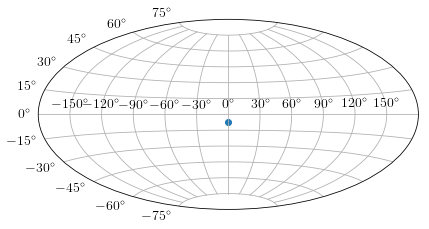

In [290]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [291]:
working_df = opsimdf

In [292]:
7*(np.pi/180.)

0.12217304763960307

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [293]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [294]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,316,1.676483,-1.082473,1.707026,1.645940,-1.113016,-1.051930
1,372,1.694120,-1.033972,1.724663,1.663577,-1.064515,-1.003429
2,441,1.708513,-0.985271,1.739056,1.677970,-1.015814,-0.954728
3,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
4,587,1.730248,-0.887672,1.760791,1.699705,-0.918215,-0.857129
5,680,1.738574,-0.838921,1.769117,1.708031,-0.869464,-0.808378
6,770,1.745690,-0.790249,1.776233,1.715147,-0.820792,-0.759706
7,857,1.751878,-0.741640,1.782421,1.721335,-0.772183,-0.711097
8,957,1.757386,-0.693017,1.787929,1.726843,-0.723560,-0.662474
9,1021,1.700932,-0.658150,1.731475,1.670389,-0.688693,-0.627607


In [295]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

In [296]:
field_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
22738,2297,3.141593,-0.130868,3.172136,3.11105,-0.161411,-0.100325


In [297]:
reload(utils)
# utils.plot_field(field_df)

<module 'lsst_tools.utils' from '/Users/berto/Code/LSST_tools/lsst_tools/utils/__init__.py'>

In [298]:
# field_df[field_df["fieldID"] == 2846]

opsimdf = utils.find_MW_extinction(opsimdf)
# field_df = opsimdf.loc[opsimdf["fieldID"] == chosenfield].head(1)

## Deep Drilling Fields:
___

* minion2016: 1427,744,2412,290,2786
* astro_lsst_01_1068: 1427,744,2412,290,2786
* Fake_Rolling: 290,2786


In [299]:
opsimdf.loc[opsimdf["fieldID"] == 505] ## WFD

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927,0.073125
736,737,1016,54,505,1.720374,-0.936476,z,89952,59581.041121,1,...,102.261170,0.701202,0.0,0.0,0.053899,4.752482,21.760884,1.701047,-0.962927,0.073125
760,761,1016,54,505,1.720374,-0.936476,z,90898,59581.052066,1,...,99.499712,0.729082,0.0,0.0,0.087567,6.236553,21.759073,1.701047,-0.962927,0.073125
1482,1483,1016,54,505,1.720374,-0.936476,z,176788,59582.046159,2,...,100.267993,0.826179,0.0,0.0,0.053899,4.727801,21.650976,1.707489,-0.962927,0.073125
15455,15455,1016,54,505,1.720374,-0.936476,r,1820874,59601.074933,21,...,87.151631,0.741071,0.0,0.0,0.049177,5.204940,23.957933,1.701047,-0.956314,0.073125
15489,15489,1016,54,505,1.720374,-0.936476,r,1822206,59601.090353,21,...,85.973354,0.590093,0.0,0.0,0.049177,4.925253,24.145835,1.701047,-0.956314,0.073125
16108,16108,1016,54,505,1.720374,-0.936476,y,1903491,59602.031146,22,...,92.235053,0.748037,0.0,0.0,1.659226,0.000000,21.354363,1.707489,-0.956314,0.073125
17079,17079,1016,54,505,1.720374,-0.936476,g,1998314,59603.128644,23,...,84.617465,0.797531,0.0,0.0,0.049266,4.790446,24.025784,1.713932,-0.956314,0.073125
25604,25604,1016,54,505,1.720374,-0.936476,i,2949082,59614.132899,34,...,85.548470,0.688025,0.0,0.0,0.049266,4.750941,23.630009,1.710710,-0.953008,0.073125
25636,25636,1016,54,505,1.720374,-0.936476,i,2950326,59614.147297,34,...,86.472221,0.721431,0.0,0.0,0.049266,4.692602,23.577192,1.710710,-0.953008,0.073125


In [300]:
opsimdf.loc[opsimdf["fieldID"] == 1427] ## DDF

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
229,230,1016,56,1427,0.925184,-0.4789,r,12057,59580.139555,0,...,84.646287,0.866285,0.0,0.0,0.755889,140.000000,24.070428,0.907976,-0.505351,0.007715
230,231,1016,56,1427,0.925184,-0.4789,r,12093,59580.139972,0,...,84.969264,0.791241,0.0,0.0,0.000000,2.000000,24.143180,0.907976,-0.505351,0.007715
231,232,1016,56,1427,0.925184,-0.4789,r,12129,59580.140389,0,...,85.037385,0.791241,0.0,0.0,0.000000,2.000000,24.141983,0.907976,-0.505351,0.007715
232,233,1016,56,1427,0.925184,-0.4789,r,12165,59580.140805,0,...,85.105955,0.859965,0.0,0.0,0.000000,2.000000,24.068792,0.907976,-0.505351,0.007715
233,234,1016,56,1427,0.925184,-0.4789,r,12201,59580.141222,0,...,85.174974,0.859965,0.0,0.0,0.000000,2.000000,24.067582,0.907976,-0.505351,0.007715
234,235,1016,56,1427,0.925184,-0.4789,r,12237,59580.141639,0,...,85.244444,0.859965,0.0,0.0,0.000000,2.000000,24.066363,0.907976,-0.505351,0.007715
235,236,1016,56,1427,0.925184,-0.4789,r,12273,59580.142055,0,...,85.314366,0.859965,0.0,0.0,0.000000,2.000000,24.065138,0.907976,-0.505351,0.007715
236,237,1016,56,1427,0.925184,-0.4789,r,12309,59580.142472,0,...,85.384741,0.859965,0.0,0.0,0.000000,2.000000,24.063905,0.907976,-0.505351,0.007715
237,238,1016,56,1427,0.925184,-0.4789,r,12345,59580.142889,0,...,85.455572,0.859965,0.0,0.0,0.000000,2.000000,24.062664,0.907976,-0.505351,0.007715
238,239,1016,56,1427,0.925184,-0.4789,r,12381,59580.143305,0,...,85.526859,0.859965,0.0,0.0,0.000000,2.000000,24.061416,0.907976,-0.505351,0.007715


In [301]:
# mjdmax = np.random.choice(mjd_to_sim)
# mjdmax = np.random.choice(mjd_to_sim)
# 
# chosenfield = 550 ## WFD
chosenfield = 2297
# chosenfield = 2786 ## DDF

mjd_to_sim = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["expMJD"]].values.T[0]
filters_to_sim = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["filter"]].values.T[0]
limiting_mags = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fiveSigmaDepth"]].values.T[0] 

filters_to_sim = np.array([b('LSST_'+x) for x in filters_to_sim])

In [302]:
extinction = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["EBV_MW"]].head(1).values[0][0]
print(extinction)

0.0286167559939


In [303]:
print(opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fieldRA"]].head(1).values[0][0])
print(opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fieldDec"]].head(1).values[0][0])


3.141593
-0.130868


In [304]:
filter_path = "/Users/berto/Code/CoCo/data/filters"
coco_root_path = "/Users/berto/Code/CoCo"

coco = pccsims.pyCoCo(b(filter_path), b(coco_root_path))

In [305]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [338]:
# z_obs = 0.007
# z_obs = 0.1
z_obs = 0.2
host_EBV = 0.2
MW_EBV = extinction
# mjdmax = 60307.314753999999
# mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
mjdmax = 59580 + 1.3* 365. ## WFD 2297

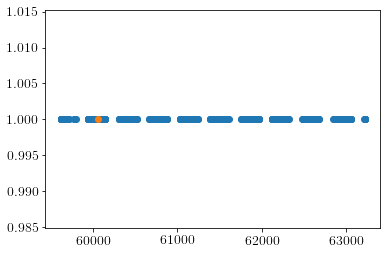

In [339]:
plt.scatter(mjd_to_sim, np.ones(len(mjd_to_sim)))
plt.scatter([mjdmax], [1])

In [340]:
# flux, flux_err = coco.simulate(b"SN2007uy", 
#                     z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)
snname = b"SN2007uy"
# snname = b"SN2009jf"
flux, flux_err = coco.simulate(snname, 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)
# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     z_obs, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [341]:
flux, flux_err

(array([  9.36048675e-40,   9.38264650e-40,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.60315746e-37,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.60557720e-29,   0.00000000e+00,   9.03363289e-19,
          9.05055404e-19,   0.00000000e+00,   0.00000000e+00,
          1.14176819e-19,   1.14470251e-19,   0.00000000e+00,
          1.86333500e-19,   1.86557242e-19,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.07753159e-17,   1.07968865e-17,   2.16226478e-17,
        

In [342]:
mjdmax 

60054.5

In [343]:
p = pcc.PhotometryClass()
pt = simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
pt_lim_m = pt
pt_lim_m["fivesigmadepth"] = limiting_mags

In [344]:
pt = pt_lim_m[np.where(pt_lim_m["flux"] > 1e-22)]

In [345]:
pt

MJD,flux,flux_err,filter,fivesigmadepth
float64,float64,float64,str6,float64
59938.319371,9.03363288896e-19,0.0,LSST_r,23.92744
59938.334474,9.05055403982e-19,0.0,LSST_r,23.924331
59941.310001,1.14176818876e-19,0.0,LSST_i,23.46749
59941.330894,1.14470250854e-19,0.0,LSST_i,23.480399
59945.321814,1.86333500041e-19,0.0,LSST_i,23.593007
59945.331708,1.86557242415e-19,0.0,LSST_i,23.562148
59962.248386,1.07753158524e-17,0.0,LSST_g,24.605787
59962.26623,1.07968865014e-17,0.0,LSST_g,24.701739
59965.260542,2.16226477752e-17,0.0,LSST_r,24.142244


In [346]:
days_before = 40
days_after = 100
print(mjdmax)
w = np.where(np.logical_and(pt["MJD"] > mjdmax - days_before, pt["MJD"] < mjdmax + days_after))
print(w)
pt[w]

60054.5
(array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


MJD,flux,flux_err,filter,fivesigmadepth
float64,float64,float64,str6,float64
60017.2883,3.1557505243e-17,0.0,LSST_r,23.90416
60017.30822,3.17306054351e-17,0.0,LSST_r,23.789152
60017.33485,2.7933057986e-18,0.0,LSST_i,23.215939
60017.348322,2.80370251145e-18,0.0,LSST_i,23.122887
60019.09153,3.62465625981e-17,0.0,LSST_g,24.111889
60019.105128,3.63779440345e-17,0.0,LSST_g,24.361027
60025.130395,1.45769984502e-17,0.0,LSST_i,24.05554
60025.152168,1.46188486463e-17,0.0,LSST_i,24.122378
60027.10001,5.79089758514e-17,0.0,LSST_u,23.509843


In [347]:
print(snname)
print(chosenfield)
print(z_obs)
print(extinction)
print(opsimdbpath)
print(mjdmax)

b'SN2007uy'
2297
0.2
0.0286167559939
/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db
60054.5


In [348]:

# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_minion_1016_SN2009jf_z=01_EBVMW=0023_EBVHOST=01_fieldID=550WFD.dat"
# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0023_EBVHOST=01_fieldID=550WFD.dat"

# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_minion_1016_SN2009jf_z=01_EBVMW=0018_EBVHOST=01_fieldID=2786DDF.dat"
# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0018_EBVHOST=01_fieldID=2786DDF.dat"

# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_minion_1016_SN2009jf_z=01_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"



# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_astro_lsst_1086_SN2009jf_z=01_EBVMW=0023_EBVHOST=01_fieldID=550WFD.dat"
# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_astro_lsst_1086_SN2007uy_z=02_EBVMW=0023_EBVHOST=01_fieldID=550WFD.dat"

# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_astro_lsst_1086_SN2009jf_z=01_EBVMW=0018_EBVHOST=01_fieldID=2786DDF.dat"
# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_astro_lsst_1086_SN2007uy_z=02_EBVMW=0018_EBVHOST=01_fieldID=2786DDF.dat"

# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0001_astro_lsst_1086_SN2009jf_z=01_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
# outpath = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_astro_lsst_1086_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"


pt[w].write(outpath, format='ascii.commented_header', overwrite=True)

In [350]:
p.load_table(pt[w], verbose= True)


p.plot()

Exception: 

In [330]:

filter_file_type = '.dat'
filter_names = np.unique(pt[w]["filter"])
print(filter_names)
pt.add_index('filter', unique = True)
for filter_name in filter_names:
#     phot_table = self.phot.loc["filter", filter_name]
    filter_filename = filter_name + filter_file_type
    print(filter_filename)

filter
------
LSST_g
LSST_i
LSST_r
LSST_u
LSST_z
LSST_g.dat
LSST_i.dat
LSST_r.dat
LSST_u.dat
LSST_z.dat


In [363]:
reload(pcc)
phot = pcc.PhotometryClass()
infile = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
phot.load(path = infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), verbose = True)
# phot.load_phot_from_file(path = infile, format = "ascii.commented_header")

phot.unpack(verbose = True)

/Users/berto/Code/verbose-enigma/pycoco/__init__.py:301: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + self.data.meta["filename"].split('/')[-1].replace('_', '\_') + '}$'
/Users/berto/Code/verbose-enigma/pycoco/__init__.py:1491: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + self.data.meta["filename"].replace('_', '\_') + '}$'
/Users/berto/Code/verbose-enigma/pycoco/__init__.py:1492: DeprecationWarning: invalid escape sequence \_
  plot_label_string_compare = r'$\rm{' + SpectrumClassInstance.data.meta["filename"].replace('_', '\_') + '}$'
/Users/berto/Code/verbose-enigma/pycoco/__init__.py:1928: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + self.spec[spec_key].data.meta["filename"].split('/')[-1].replace('_', '\_') + '}$'
/Users/berto/Code/verbose-enigma/pycoco/__init__.py:2038: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + self.mangledspec[spec_key].da

Exception: 

In [359]:
phot.data

OrderedDict()

In [366]:
phot_table = Table.read(infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), format = "ascii")

In [368]:
        phot_table.meta["filename"] = infile

        phot_table["MJD"].unit = u.day
        phot_table["flux"].unit = u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s
        phot_table["flux_err"].unit =  phot_table["flux"].unit

In [372]:
reload(pcc)
p = pcc.PhotometryClass()
p.load_table(phot_table, verbose = True)

Exception: 